# Прогнозирование оттока и кластеризация клиентов фитнес-центров 


**Центральная задача** - выбор модели прогноза оттока, кластеризация клиентов и разработка маркетинговых действий. 

<h3>Описание данных</h3>


***В распоряжении один датасет:***

**Таблица df (данные на месяц до оттока и факт оттока на определённый месяц):**


- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

<h3> Этапы исследования </h3>

1. Предобработка данных.
2. Исследовательский анализ - EDA.
3. Обучение и прогноз оттока пользователей.
4. Кластеризация.
5. Выводы.

**0. Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('/datasets/gym_churn.csv')

**1. Предобработка данных**

In [4]:
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.columns=df.columns.str.lower()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [7]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

In [8]:
df['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

**Пропусков в данных нет, все столбцы в правильном формате. Бинарный столбец churn (факт оттока) содержит два значения - 1 и 0, все верно. Для удобства названия столбцов приведены к нижнему регистру.** 

**2. Исследовательский анализ - EDA.**

In [9]:
print(df.shape)
df.info()

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


- **Размер датафрейма: 4000 строк (наблюдений), 14 колонок (13 признаков и 1 факт оттока - целевая переменная);**
- **Из 13 признаков 6 числовых и 7 категориальных (из них 6 бинарных), целевая переменная - бинарная;**
- **Временная структура отсутствует;**
- **Пропусков значений у признаков нет.**

In [10]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [11]:
count_churn=df.pivot_table(index='churn', values='age',aggfunc='count')
count_churn.columns=['count_churn']
display(count_churn)
display(df.pivot_table(index='churn', aggfunc='mean').round(2))

,count_churn
churn,
0,2939
1,1061


,age,avg_additional_charges_total,avg_class_frequency_current_month,avg_class_frequency_total,contract_period,gender,group_visits,lifetime,month_to_end_contract,near_location,partner,phone,promo_friends
churn,,,,,,,,,,,,,
0,29.98,158.45,2.03,2.02,5.75,0.51,0.46,4.71,5.28,0.87,0.53,0.9,0.35
1,26.99,115.08,1.04,1.47,1.73,0.51,0.27,0.99,1.66,0.77,0.36,0.9,0.18


**Среди средних значений признаков по двум группам - "остались" (0)/"ушли" (1), заметны явные различия:**

- среднее число посещений в неделю по данным за последний месяц у клиентов "остались", почти в два раза больше. 
- средний срок абонемента у клиентов группы "остались" 5.75 месяца, а у клиентов группы "ушли" 1.73.
- показатель посещения групповых занятий у клиентов группы "остались" в два раза выше.
- среднее время с момента первого обращения в фитнес-центр у группы "ушли" значительно ниже, примерно 1 месяц против 4.7 у группы "остались"

**Также, были замечены признаки, по которым нет явных различий:**

- пол, то есть отток не зависит от пола клиента.
- проживание или работа в районе, где находится фитнес-центр - небольшое отличие есть, но оно незначительно: (0.87 у "остались" и 0.77 у "ушли"). 

In [12]:
churn_true=df[df['churn']==1]
churn_false=df[df['churn']==0]

------------------------------------ Гистограммы - распределение для числовых признаков -------------------------------


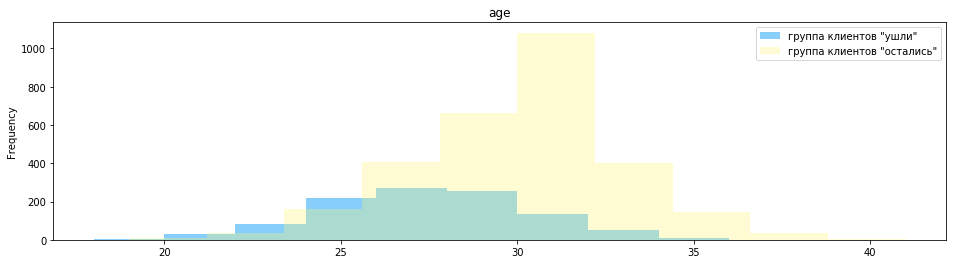

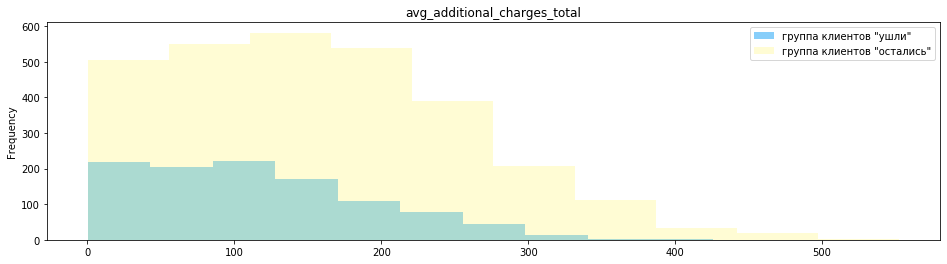

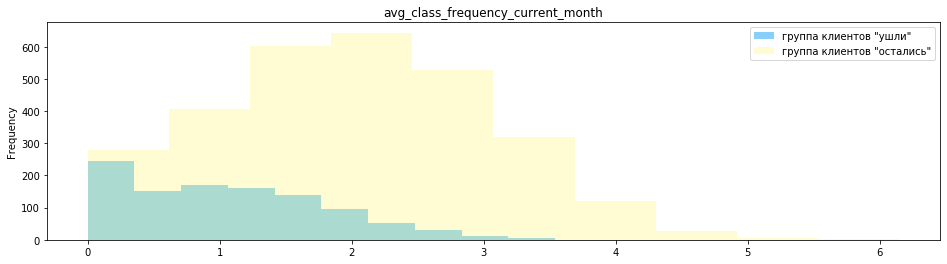

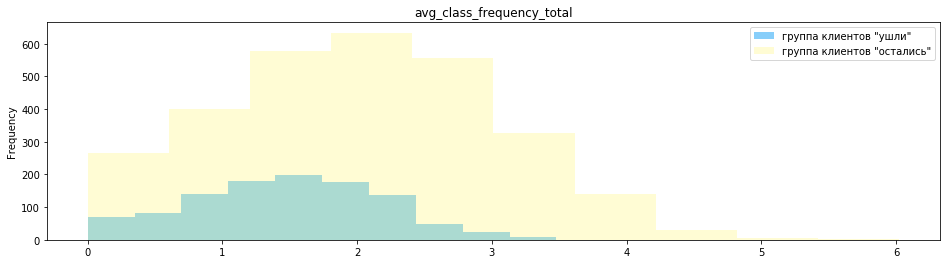

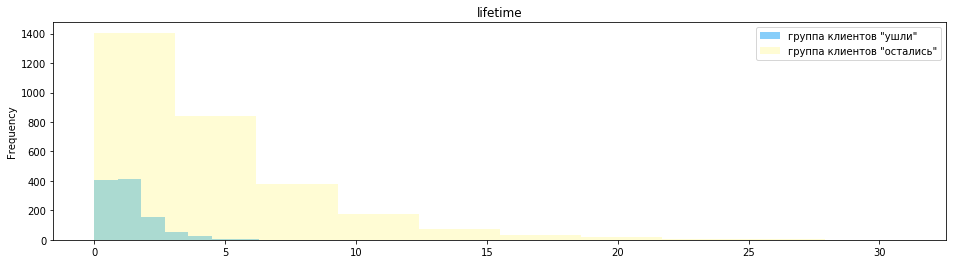

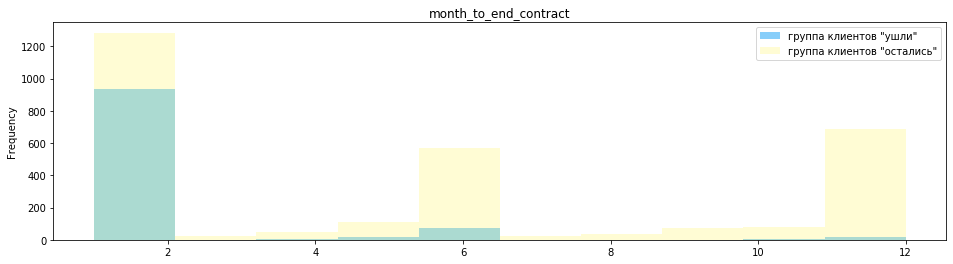

In [13]:
print('------------------------------------ Гистограммы - распределение для числовых признаков -------------------------------')
numeric_variable=['age','avg_additional_charges_total','avg_class_frequency_current_month',
                 'avg_class_frequency_total','lifetime','month_to_end_contract']
for i in numeric_variable:
    
    ax_1=churn_true[i].plot(kind='hist', bins=10, color='#87CEFA', label='группа клиентов "ушли"' )
    churn_false[i].plot(kind='hist',bins=10, ax=ax_1, alpha=0.3, figsize=(16,4),color='#FFF773', label='группа клиентов "остались"')
    plt.legend()
    plt.title(i)
    plt.show()

- **Распределения числовых признаков в целом нормальные, за исключением признака month_to_end_contract - этот признак хоть и числовой, но зависит от категориального признака contract_period, поэтому у него такой ненормальный вид.** 
- **Значительных выбросов не наблюдается.**

------------------------------------ Гистограммы для категориальных признаков -------------------------------


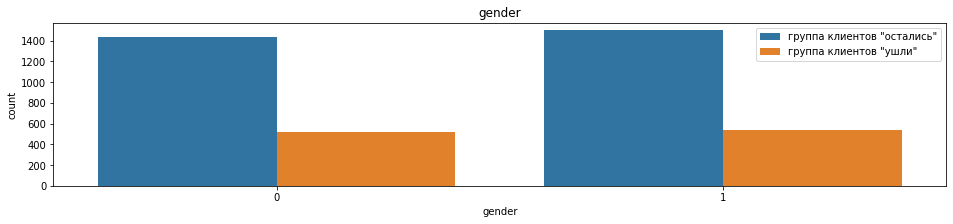

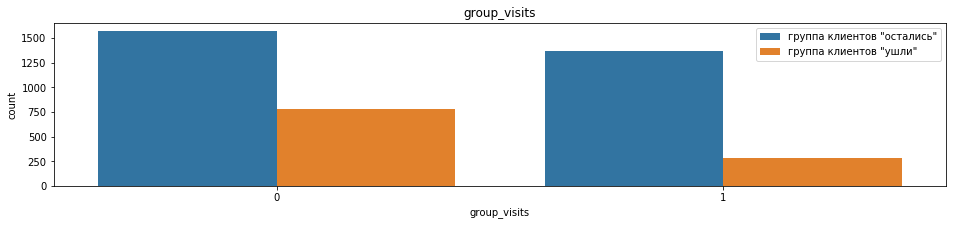

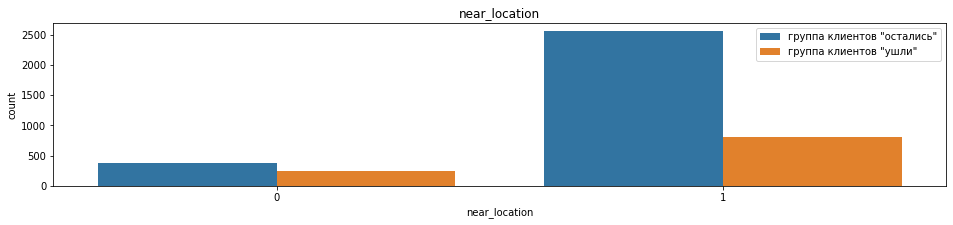

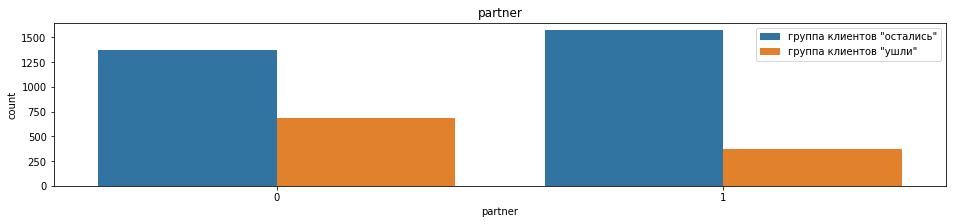

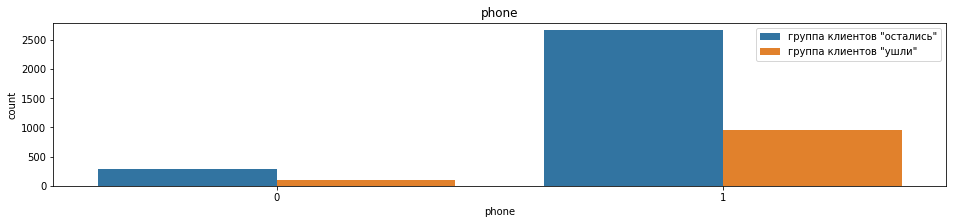

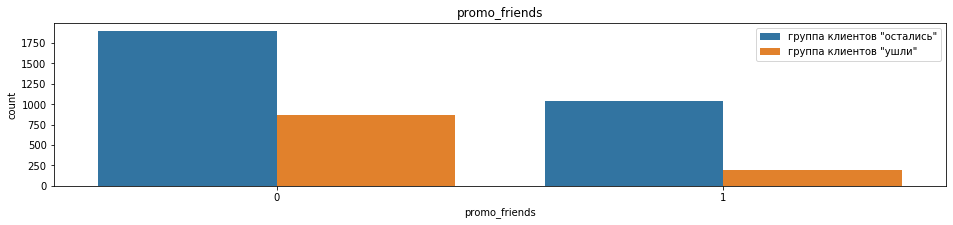

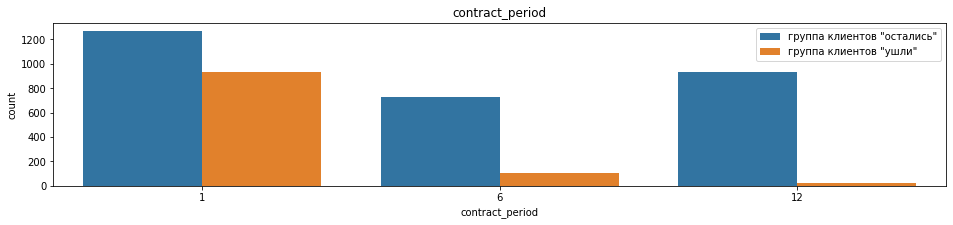

In [14]:
print('------------------------------------ Гистограммы для категориальных признаков -------------------------------')
numeric_variable=['gender','group_visits','near_location','partner','phone','promo_friends','contract_period']
for i in numeric_variable:
    plt.figure(figsize=(16,3))
    sns.countplot(x=i, hue='churn', data=df)
    plt.title(i)
    plt.legend(['группа клиентов "остались"', 'группа клиентов "ушли"'])
    plt.show()

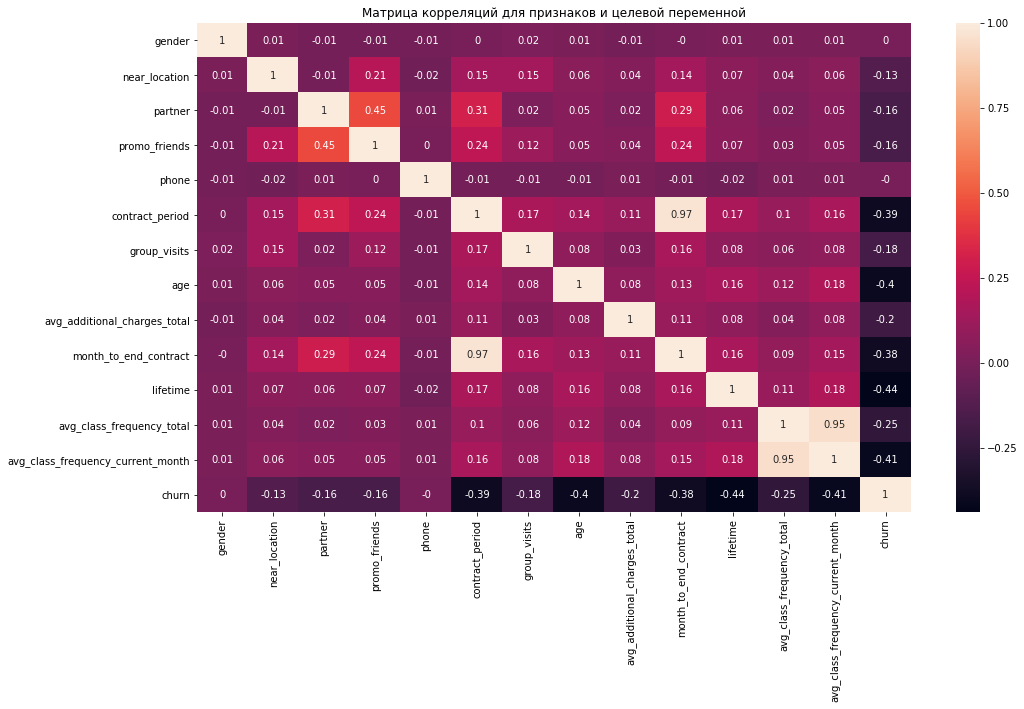

In [15]:
cm = df.corr().round(2)
fig = plt.subplots(figsize=(16,9))
sns.heatmap(cm, annot=True) 
plt.title('Матрица корреляций для признаков и целевой переменной')
plt.show()

In [16]:
df_model=df.drop(['contract_period','avg_class_frequency_total'],axis=1)

**Матрица корреляций выявила две пары сильно-зависимых признаков: month_to_end_contract - contract_period (корреляция 0.97) и avg_class_frequency_current_month - avg_class_frequency_total (корреляция 0.95). Для улучшения модели (избавление от мультиколлинеарности) избавимся от одного признака из пары.** Из пары month_to_end_contract - contract_period, contract_period менее важен, чем month_to_end_contract, так как, на первый взгляд, кажется, что остаток срока абонемента может оказывать более серьезное влияние на отток, чем первоначальный срок абонемента. А из пары  avg_class_frequency_current_month - avg_class_frequency_total, наиболее важный признак - avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц), так как для переменной отток важен именно ближайшее к оттоку поведение клиента, а не поведение за весь срок абонемента. **Таким образом, в итоговый датасет для модели признаки - contract_period и avg_class_frequency_total не войдут.**

***На основе EDA можно сделать вывод о том, что модель может быть полезной с таким качеством исходных данных.***

**3. Обучение и прогноз оттока пользователей**

In [17]:
X=df_model.drop('churn',axis=1)
y=df_model['churn']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
# Логистическая регрессия

model_log=LogisticRegression(random_state=0)
model_log.fit(X_train, y_train)
predictions = model_log.predict(X_test)

In [20]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))

Accuracy: 0.90
Precision: 0.80
Recall: 0.79


In [21]:
# Случайный лес

model_for=RandomForestClassifier(random_state=0)
model_for.fit(X_train, y_train)
predictions = model_for.predict(X_test)

In [22]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))

Accuracy: 0.89
Precision: 0.80
Recall: 0.77


**На основании метрик accuracy, precision и recall лучше себя показывает модель "логистическая регрессия", по показателям accuracy и precision модели равны, а вот recall у модели "случайный лес" ниже.** 

In [23]:
# Важность признаков "Логистическая регрессия"
print(model_log.classes_)
feature_weights = model_log.coef_[0].round(3)
fi_df = pd.DataFrame({'feature': X.columns, 'importance': feature_weights})
print(fi_df)

[0 1]
                              feature  importance
0                              gender       0.175
1                       near_location       0.022
2                             partner      -0.045
3                       promo_friends      -0.479
4                               phone       0.223
5                        group_visits      -0.666
6                                 age      -0.190
7        avg_additional_charges_total      -0.005
8               month_to_end_contract      -0.286
9                            lifetime      -0.968
10  avg_class_frequency_current_month      -1.110


**Наибольшие коэффициенты по модолю, а значит и наибольшее влияние на прогноз оказывают признаки: avg_class_frequency_current_month (-1.110), lifetime (-0.968), group_visits (-0.67), promo_friends (-0.479).** Они все отрицательные, а отрицательный коэффициент соответствует результату 0 (ложь), то есть в нашем случае это "нет оттока".
group_visits и promo_friends бинарные признаки с отрицательными коэффициентами, поэтому для уменьшения оттока клиентов необходимо удерживать значения этих признаков на 1 (истина).
avg_class_frequency_current_month и lifetime числовые признаки с отрицательными коэффициентами, поэтому для уменьшения оттока клиентов необходимо увеличивать значения этих признаков. 

В модели всего три положительных коэффициента:  gender (0.175), near_location (0.022) и phone (0.223). Все они довольно низкие и не могут оказать серьезное влияние на прогноз. 

**4. Кластеризация**

In [24]:
# Стандартизация

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [25]:
# Дендограмма иерархической кластеризации

linked = linkage(X_sc, method = 'ward')

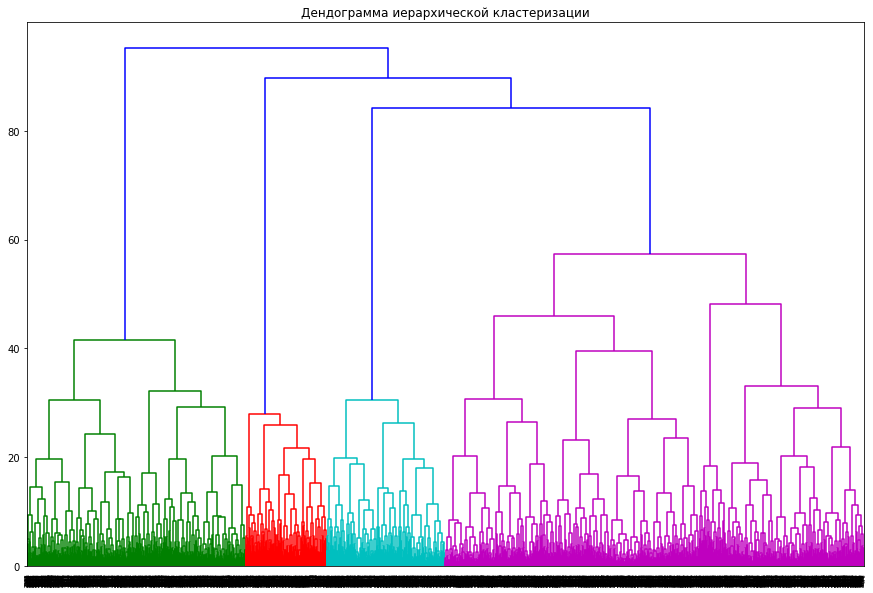

In [26]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма иерархической кластеризации')
plt.show()

На дендограмме явно выделяются 4 основных класса, расстояние между которыми доходит до 80. Однако, один из четырех классов можно разделить еще - фиолетовый класс, если принять расстояние, после которого мы перестаём объединять объекты на уровне 50. 

**Таким образом, примем разделение на 5 классов с пороговым расстоянием в 50.**

In [27]:
# Кластеризация K-means

km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_sc)

In [28]:
silhouette_score(X_sc, labels).round(2)

0.14

**Качество кластеризации, согласно silhouette score, оказалось не на очень высоком уровне:** значение метрики 0.14 (значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация). **Таким образом, данную кластеризацию необходимо обсудить с экспертами и оценить ее работоспособность в процессе работы.**  

In [29]:
df['cluster']=labels

In [30]:
count_user=df.pivot_table(index='cluster', values='age', aggfunc='count')
count_user.columns=['count_users']
display(count_user)
pivot_cluster=df.pivot_table(index='cluster', aggfunc='mean').round(2)
pivot_cluster

,count_users
cluster,
0,558
1,1042
2,386
3,1025
4,989


,age,avg_additional_charges_total,avg_class_frequency_current_month,avg_class_frequency_total,churn,contract_period,gender,group_visits,lifetime,month_to_end_contract,near_location,partner,phone,promo_friends
cluster,,,,,,,,,,,,,,
0,28.68,137.13,1.60,1.76,0.40,2.99,0.50,0.23,2.97,2.82,0.00,0.49,1,0.08
1,27.54,116.21,1.17,1.43,0.57,2.11,0.49,0.29,1.89,1.99,1.00,0.22,1,0.07
2,29.30,144.21,1.72,1.85,0.27,4.78,0.52,0.43,3.94,4.47,0.86,0.47,0,0.31
3,30.69,178.07,2.33,2.33,0.02,6.04,0.55,0.52,5.38,5.54,1.00,0.38,1,0.01
4,29.60,153.67,1.92,1.96,0.12,6.90,0.50,0.52,4.28,6.31,1.00,0.89,1,1.00


Средние значения признаков по кластерам отличаются, некоторые признаки отличаются незначительно, а некоторые, наоборот, демонстрируют явную разницу. **Один из сильно отличающихся признаков, который, в свою очередь, является основным в данном исследовании - отток клиентов (churn). Кластеры от наименьшей к наибольшей доле оттока клиентов: 0 (доля оттока 0.02), 2 (0.12), 4 (0.27), 3 (0.40), 1 (0.57). Более внимательно посмотрим крайние по оттоку кластеры - кластер 0 и кластер 1, что их отличает:** 

- по числу клиентов эти кластеры практически равны (кластер 0 - 1025, 1 - 1042)
- суммарная выручка от других услуг фитнес-центра, значительная разница (0 - 178.07, 1 - 116.21). Клиенты кластера с меньшем оттоком тратят денег больше на сопутствующие услуги чем клиенты из кластера 1. 
- среднее число посещений в неделю за все время и за последний месяц значительно выше (в два раза) у клиентов кластера с меньшем оттоком. 
- средний период абонемента также сильно больше у клиентов кластера с меньшем оттоком (кластер 0 - 6.04 месяца, 1 - 2.11 месяца).
- доля клиентов посетивших групповые занятия у клиентов кластера с меньшем оттоком снова больше (кластер 0 - 0.52, 1 - 0.29)
- по времени с момента первого обращения в фитнес-центр кластер с наибольшим оттоком также проигрывает (кластер 0 - 5.38 месяца, 1 - 1.89 месяца).

**Признаки, не оказывающие заметного влияния на долю оттока:**

- пол;
- факт проживания или работы в районе, где находится фитнес-центр;
- статус клиента - сотрудник компании-партнёра клуба;
- факт первоначальной записи в рамках акции «приведи друга».

------------------------------------ Гистограммы - распределение для числовых признаков -------------------------------


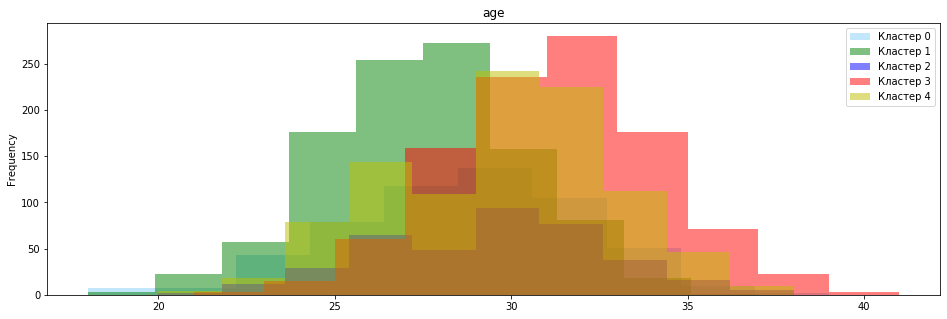

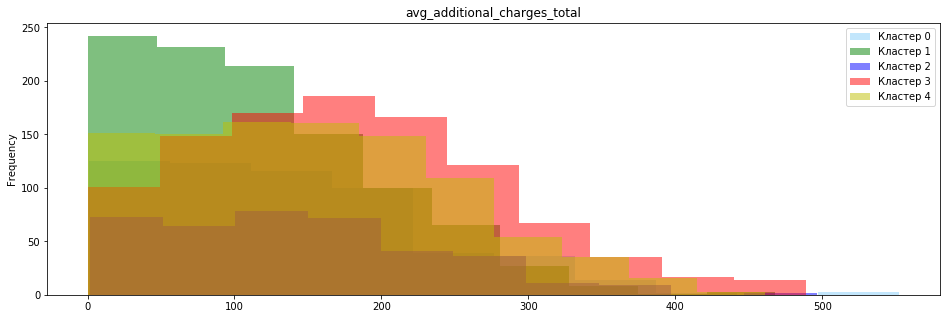

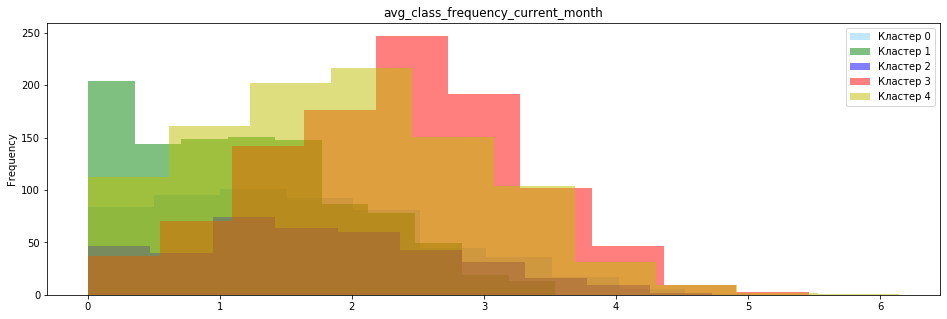

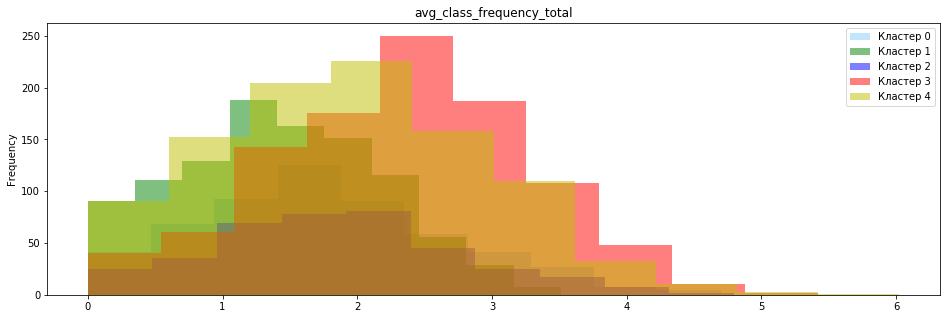

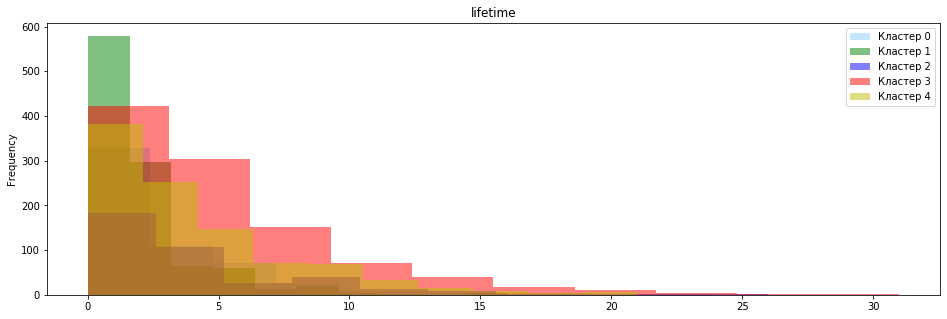

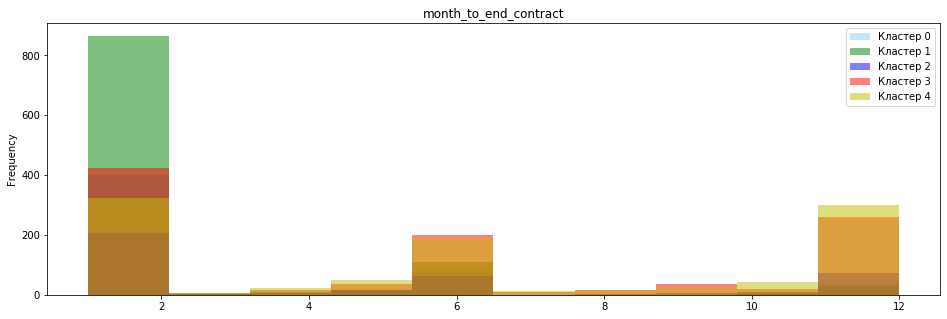

In [31]:
print('------------------------------------ Гистограммы - распределение для числовых признаков -------------------------------')
numeric_variable=['age','avg_additional_charges_total','avg_class_frequency_current_month',
                 'avg_class_frequency_total','lifetime','month_to_end_contract']


for i in numeric_variable:
        
    ax_1=df[df['cluster']==0][i].plot(kind='hist', bins=10, color='#87CEFA', alpha=0.5, figsize=(16,5), label='Кластер 0')
    df[df['cluster']==1][i].plot(kind='hist', bins=10, color='g', ax=ax_1, alpha=0.5,label='Кластер 1')
    df[df['cluster']==2][i].plot(kind='hist', bins=10, color='b', ax=ax_1, alpha=0.5, label='Кластер 2')
    df[df['cluster']==3][i].plot(kind='hist', bins=10, color='r', ax=ax_1, alpha=0.5, label='Кластер 3')
    df[df['cluster']==4][i].plot(kind='hist', bins=10, color='y', ax=ax_1, alpha=0.5, label='Кластер 4') 
    plt.legend()
    plt.title(i)
    plt.show()

------------------------------------ Гистограммы для категориальных признаков -------------------------------


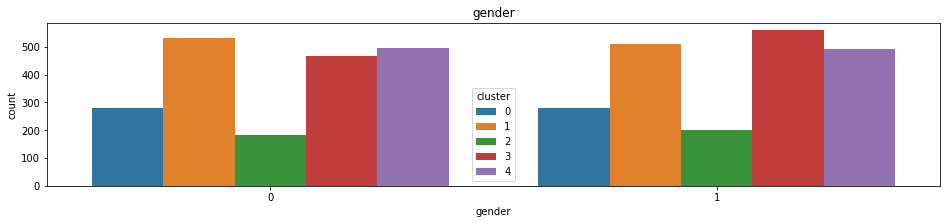

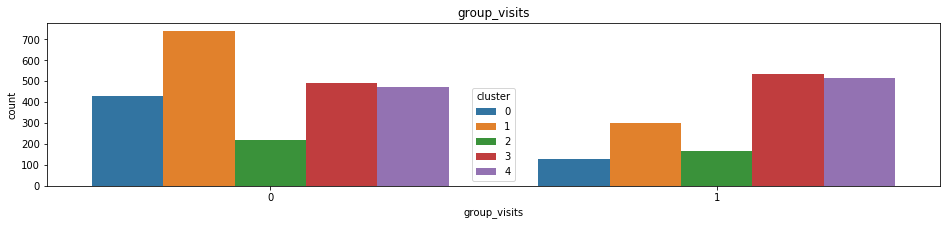

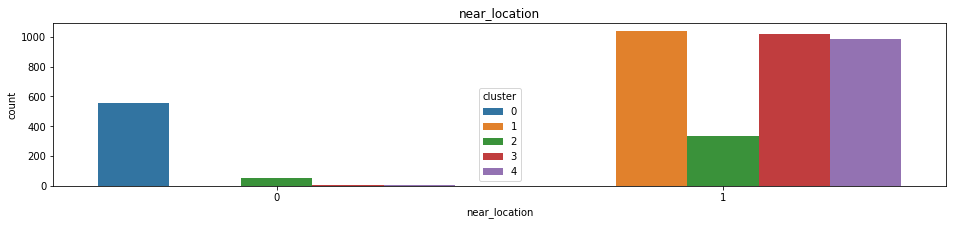

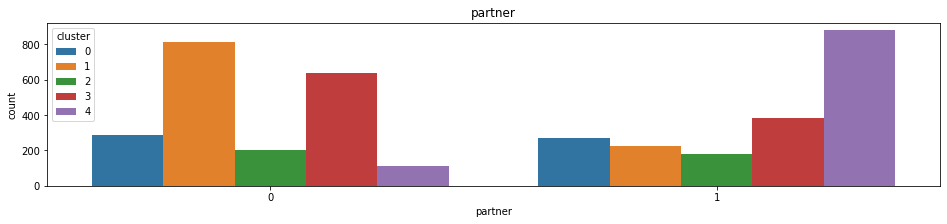

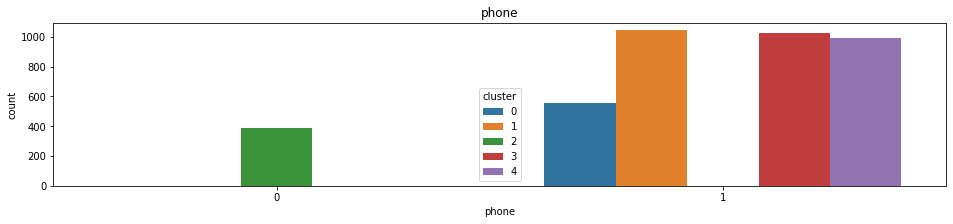

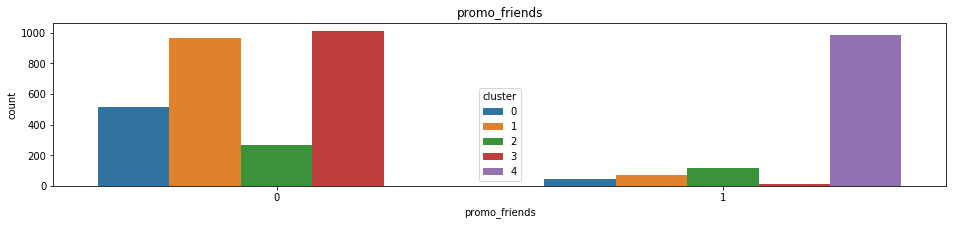

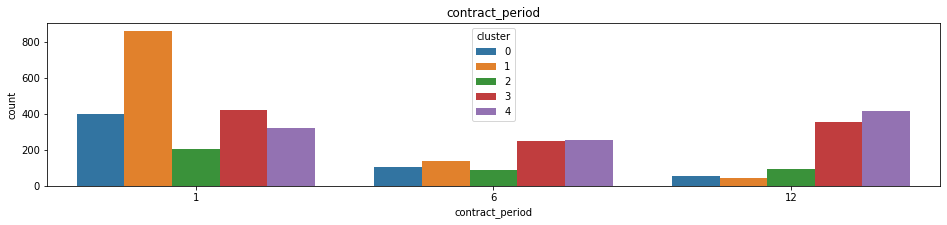

In [32]:
print('------------------------------------ Гистограммы для категориальных признаков -------------------------------')
numeric_variable=['gender','group_visits','near_location','partner','phone','promo_friends','contract_period']
for i in numeric_variable:
    plt.figure(figsize=(16,3))
    sns.countplot(x=i, hue='cluster', data=df)
    plt.title(i)
    plt.show()

По таблице со средними значениями признаков, распределениям числовых и категориальных признаков можно составить характерные портреты клиентов в разрезе кластеров:

***Кластер 0 (самый надежный кластер, наименьшая доля отток: 0.02):*** по половому признаку практически равенство, небольшой перевес у пола 1. Средний возраст клиентов (около 31 года) выше, чем у других кластеров. Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 1 или 12 месяцев. Чаще других посещают зал в неделю (почти 2.5 раза за все время наблюдений) и больше тратят на сапутствующие услуги.

***Кластер 1 (самый ненадежный кластер, наибольшая доля оттока: 0.57):*** по половому признаку практически равенство, небольшой перевес у пола 0. Средний возраст клиентов (около 27.5 года) ниже, чем у других кластеров. Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 1 месяц. Реже других посещают зал в неделю (около 1 раза) и меньше тратят на сопутствующие услуги.

***Кластер 2 (надежный кластер, доля оттока: 0.12):*** по половому признаку равенство. Средний возраст клиентов (около 30 лет). Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 12 месяцев. В неделю зал посещают около 2 раз и тратят средние среди классов средства на сопутствующие услуги.

***Кластер 3 (ненадежный кластер, доля оттока: 0.40):*** по половому признаку равенство. Средний возраст клиентов (около 28.7 лет). Клиенты кластера не проживают и не работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 1 месяц. В неделю зал посещают около 1.6 раза и траты на сапутствующие услуги ниже, чем у надежных кластеров (кластеры с меньшей долей оттока).

***Кластер 4 (средний по надежности, доля оттока: 0.27):*** по половому признаку равенство. Средний возраст клиентов (около 29.3 лет). Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Немного чаще покупают абонементы на 1 месяц. В неделю зал посещают около 2 раз и тратят средние среди классов средства на сопутствующие услуги.

**По портретам клиентов разных кластеров прослеживается важная закономерность:** 

- клиенты от 29 и выше лет более надежные, чем клиенты до 29 лет. 
- клиенты приобретающие абонемент на 1 месяц и посещающие зал меньше 2-х раз в неделю менее надежные.
- клиенты тратящие больше на сопутствующие услгуи зала более надежные. 

**5.Выводы**

***Выбор модели прогнозирования:***

Для прогноза факта оттока пользователей можно использовать обе из предложенных моделей (логистическая регрессия и случайный лес), по метрикам accuracy, precision и recall они практически равны, немного лучше по показателю recall себя показывает модель "логистическая регрессия". **Так как "случайный лес" (метод из класса ансамблей) более сложный для интерпретации, лучше использовать модель "логистический лес".**

**Наибольшие коэффициенты модели "логистический лес" по модулю, а значит и наибольшее влияние на прогноз оказывают признаки: avg_class_frequency_current_month (-1.110), lifetime (-0.968), group_visits (-0.67), promo_friends (-0.479).** Они все отрицательные, а отрицательный коэффициент соответствует результату 0 (ложь), то есть в нашем случае это "нет оттока". group_visits и promo_friends бинарные признаки с отрицательными коэффициентами, поэтому для уменьшения оттока клиентов необходимо удерживать значения этих признаков на 1 (истина). avg_class_frequency_current_month и lifetime числовые признаки с отрицательными коэффициентами, поэтому для уменьшения оттока клиентов необходимо увеличивать значения этих признаков.

***Кластеризация клиентов:***

***Кластер 0 (самый надежный кластер, наименьшая доля отток: 0.02):*** по половому признаку практически равенство, небольшой перевес у пола 1. Средний возраст клиентов (около 31 года) выше, чем у других кластеров. Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 1 или 12 месяцев. Чаще других посещают зал в неделю (почти 2.5 раза за все время наблюдений) и больше тратят на сапутствующие услуги.

***Кластер 1 (самый ненадежный кластер, наибольшая доля оттока: 0.57):*** по половому признаку практически равенство, небольшой перевес у пола 0. Средний возраст клиентов (около 27.5 года) ниже, чем у других кластеров. Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 1 месяц. Реже других посещают зал в неделю (около 1 раза) и меньше тратят на сопутствующие услуги.

***Кластер 2 (надежный кластер, доля оттока: 0.12):*** по половому признаку равенство. Средний возраст клиентов (около 30 лет). Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 12 месяцев. В неделю зал посещают около 2 раз и тратят средние среди классов средства на сопутствующие услуги.

***Кластер 3 (ненадежный кластер, доля оттока: 0.40):*** по половому признаку равенство. Средний возраст клиентов (около 28.7 лет). Клиенты кластера не проживают и не работают в районе, где находится фитнес-центр. Чаще покупают абонементы на 1 месяц. В неделю зал посещают около 1.6 раза и траты на сапутствующие услуги ниже, чем у надежных кластеров (кластеры с меньшей долей оттока).

***Кластер 4 (средний по надежности, доля оттока: 0.27):*** по половому признаку равенство. Средний возраст клиентов (около 29.3 лет). Клиенты кластера проживают или работают в районе, где находится фитнес-центр. Немного чаще покупают абонементы на 1 месяц. В неделю зал посещают около 2 раз и тратят средние среди классов средства на сопутствующие услуги.

**По портретам клиентов разных кластеров прослеживается важная закономерность:** 

- клиенты от 29 и выше лет более надежные, чем клиенты до 29 лет. 
- клиенты приобретающие абонемент на 1 месяц и посещающие зал меньше 2-х раз в неделю менее надежные.
- клиенты тратящие больше на сопутствующие услгуи зала более надежные. 

***Рекомендации по работе с клиентами:***

- **Для менее надежных кластеров (клиентов) необходимо более сильное использование маркетинговых инструментов, направленных на удержание:** постоянные рассылки и звонки с напоминанием о себе, приглашение на внутренние мероприятия фитнес-центра, продвижение услуг фитнес-тренеров, продвижение продления абонементов по специальным ценам. 
- **Для надежных кластеров (клиентов) необходимо использовать инструменты лояльности для постоянных клиентов:** акции/скидки на абонементы для постоянных клиентов, приятные подарки и бонусы для постоянных клиентов, удержание качества услуг на стабильном уровне.  